In [1]:
import os
os.chdir("..")

import pathpy as pp
import pandas as pd
from pathpy import Network
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

import importlib

from typing import TYPE_CHECKING, Dict, List, Tuple, Union, Any
import scipy as sp
from scipy.sparse import linalg as spl
import numpy as np

from collections import defaultdict 
from collections.abc import Iterable
from __future__ import annotations
from typing import TYPE_CHECKING, Union, Dict, Tuple

import my_functions

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

In [2]:
PLOT_PATH = 'Pathpy 2 code/plots/'
FLIGHT_PATH = '/writeup/flight_net/'
TOY_PATH = 'writeup/toy_net/'

# Load selection of networks
This project will just focus on the flights and toy_net_2 datasets

In [3]:
toy_net_2 = my_functions.toy_net_2()

# from paths dataset - 1% sample to start
flight_paths= pp.Paths.read_file("Data/US flights 2011/US flights od.ngram", separator=',', frequency=True)
flights = pp.Network.from_paths(flight_paths)
flights_m2 = pp.HigherOrderNetwork(flight_paths, k=2)

# from paths dataset - use this instead
tube_paths = pp.Paths.read_file("Data/Tube/tube_paths_train.ngram", separator=',', frequency=True)
tubes = pp.Network.from_paths(tube_paths)
#m1 = pp.HigherOrderNetwork(tube_paths, k=2)

# from taxi dataset
# from paths dataset - use this instead
taxi_paths = pp.Paths.read_file("Data/SF taxis/SF taxis od.ngram", separator=',', frequency=True)
taxis = pp.Network.from_paths(taxi_paths)
    
# turtles - super interesting: puts most nodes in one group and assigns the others their own
tortoises = pp.Network.read_file('Data/reptilia-tortoise-network-bsv/reptilia-tortoise-network-bsv.edges',header=True,separator=' ',directed=False)

2021-05-10 01:52:55 [Severity.INFO]	Reading ngram data ... 
2021-05-10 01:52:55 [Severity.INFO]	finished. Read 358 paths with maximum length 7
2021-05-10 01:52:55 [Severity.INFO]	Calculating sub path statistics ... 
2021-05-10 01:52:55 [Severity.INFO]	finished.
2021-05-10 01:52:55 [Severity.INFO]	Reading ngram data ... 
2021-05-10 01:52:56 [Severity.INFO]	finished. Read 61748 paths with maximum length 35
2021-05-10 01:52:56 [Severity.INFO]	Calculating sub path statistics ... 
2021-05-10 01:53:02 [Severity.INFO]	finished.
2021-05-10 01:53:02 [Severity.INFO]	Reading ngram data ... 
2021-05-10 01:53:02 [Severity.INFO]	finished. Read 53 paths with maximum length 20
2021-05-10 01:53:02 [Severity.INFO]	Calculating sub path statistics ... 
2021-05-10 01:53:02 [Severity.INFO]	finished.
2021-05-10 01:53:02 [Severity.INFO]	Reading edge list ... 
2021-05-10 01:53:02 [Severity.INFO]	finished.


# Flights network
## Explore network structure and time scales: 


In [4]:
net = flights # choose which net
option = 2    # use my transition matrix and Laplacian with teleportation
#net.remove_node(12) # uncomment for toy net toy net

# paths to save plots
FLIGHT_PATH = 'writeup/flight_net/'
TOY_PATH = 'writeup/toy_net/'

# visualise net in pathpy
net

Text(0, 0.5, 'Nodes (subset)')

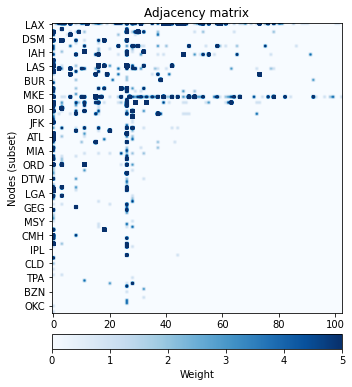

In [5]:
# viz single adjacency matrix
fig, ax = plt.subplots(1,1,figsize=(6,6))

A = net.adjacency_matrix().todense()
im = ax.imshow(A,cmap="Blues",clim=(0,5))
my_functions.colorbar(im,label="Weight")

node_list = list(net.nodes.keys())
xticks = list(net.nodes.keys())
x = np.arange(len(node_list))
x,xticks = my_functions.every_nth_label(x,xticks,5) # change number of ticks displayed on y-axis

#ax.set(xticks=x, xticklabels=xticks) # looks a little messy for big nets
ax.set(yticks=x, yticklabels=xticks)
ax.set_title('Adjacency matrix')
ax.set_ylabel('Nodes (subset)')

#plt.savefig(FLIGHT_PATH+'flights_adjacency.png')

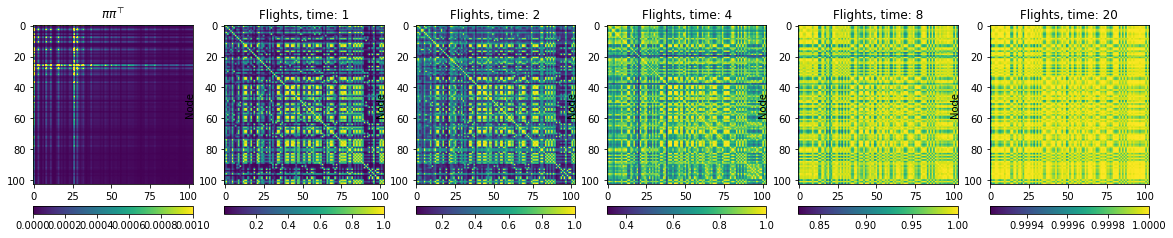

In [6]:
# see how transition matrix evolves with time
# T is row stochastic (T)ij : i -> j
if option == 1:
    T = net.transition_matrix().todense().T
elif option == 2:
    T = my_functions.transition_mat(net)

pi_t = np.array(list(pp.algorithms.centralities.pagerank(net).values()))
pipi_T = np.outer(pi_t,pi_t)

times = [1,2,4,8,20]
fig,ax = plt.subplots(1,6,figsize=(20,20))
im1 = ax[0].imshow(pipi_T,clim=(0,1e-3))
ax[0].set_title(r'$\pi \pi^\top$')
my_functions.colorbar(im1)

i=1
for time in times:
    Tn = T**time
    Tn = my_functions.row_normalise(Tn)
    # bilinear product of all rows of T
    im = ax[i].imshow(Tn @ Tn.T)
    ax[i].set_title('Flights, time: {}'.format(time))
    ax[i].set_ylabel("Node")
    my_functions.colorbar(im)
    i = i + 1
    
#plt.savefig(FLIGHT_PATH+'flights_timescales')

# Similarity matrices

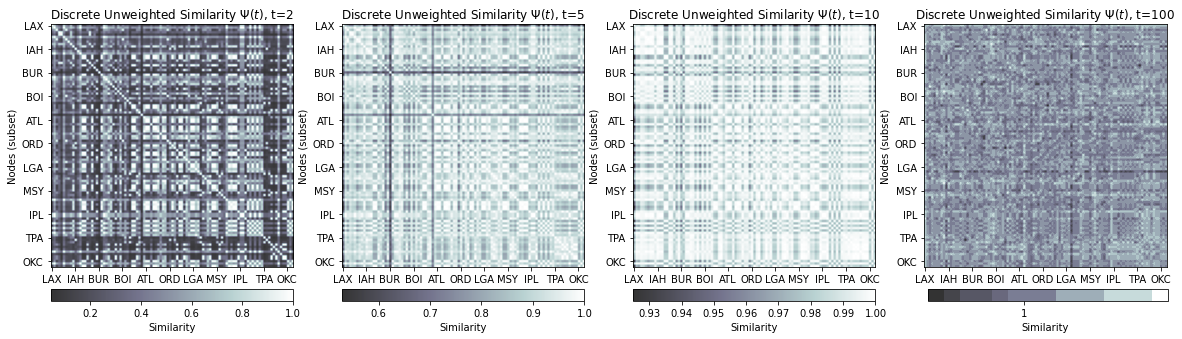

In [7]:
# simple, unweighted discrete-time similarity matrices
# all similarity should tend to 1 as t increases because all rows of T are the same at stationarity
importlib.reload(my_functions)

alpha = 0.9
if option == 1:
    T = net.transition_matrix().todense().T
elif option == 2:
    T = my_functions.transition_mat(net)

nsteps = [2,5,10,100]
fig,ax = plt.subplots(1,4,figsize=(20,10))

node_list = list(net.nodes.keys())
xticks = list(net.nodes.keys())
x = np.arange(len(node_list))
x,xticks = my_functions.every_nth_label(x,xticks,10)


c=[1,1,1,1] # option to specify scales

i=0
for n in nsteps:
    Tn = T**n
    Tn = my_functions.row_normalise(Tn,p=2)
    Psi = (Tn) @ (Tn.T)
    imx = ax[i].imshow(Psi,cmap="bone",alpha=0.8) #,clim=(0,c[i])
    ax[i].set_title(r'Discrete Unweighted Similarity $\Psi(t)$, t='+str(n))#+r', $\alpha =$ '+str(alpha))
    ax[i].set_ylabel('Nodes (subset)')
    ax[i].set(xticks=x, xticklabels=xticks)
    ax[i].set(yticks=x, yticklabels=xticks)
    my_functions.colorbar(imx,label="Similarity")
    i = i+1

#plt.savefig(FLIGHT_PATH+'DTRWu_Similarity_flights')


The block structure of these similarity matrices identifies groups of nodes which have similar dynamical roles for timescales $\sim t$

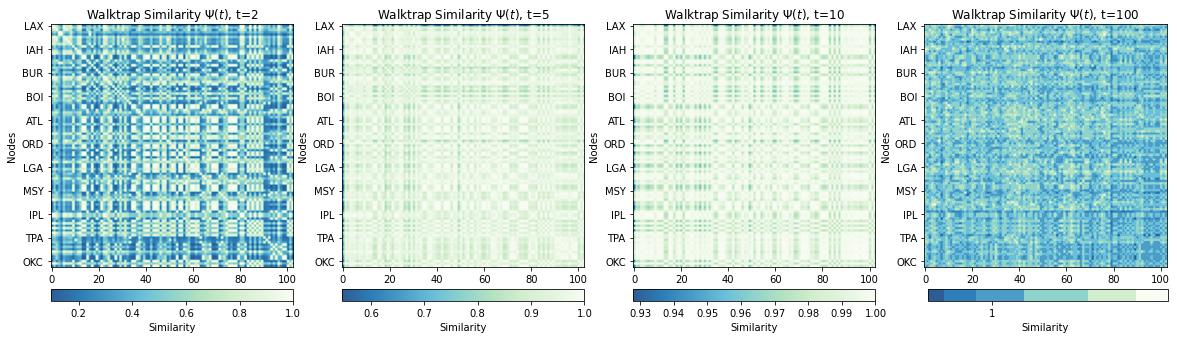

In [8]:
# Walktrap discrete-time similarity matrices
importlib.reload(my_functions)
alpha = 0.9
nsteps = [2,5,10,100]
fig,ax = plt.subplots(1,4,figsize=(20,10))

i=0
for n in nsteps:
    Psi = my_functions.walktrap_similarity(net, alpha=alpha, n=n,option=2)
    imx = ax[i].imshow(Psi,cmap="GnBu_r",alpha=0.85) 
    ax[i].set_title(r'Walktrap Similarity $\Psi(t)$, t='+str(n))#+r', $\alpha =$ '+str(alpha))
    ax[i].set_ylabel('Nodes')
    #ax[i].set(xticks=x, xticklabels=xticks)
    ax[i].set(yticks=x, yticklabels=xticks)
    my_functions.colorbar(imx,label="Similarity")
    i = i+1

#plt.savefig(FLIGHT_PATH+'Walktrap_Similarity_flights.png')

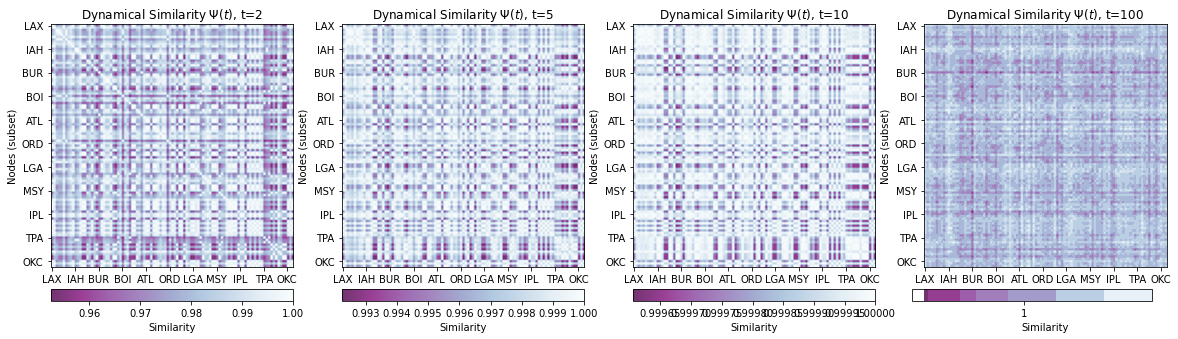

In [9]:
# may need to fix transposes 
importlib.reload(my_functions)
times = [2,5,10,100]
fig,ax = plt.subplots(1,4,figsize=(20,10))

i=0
for t in times:
    Psi = my_functions.dynamical_similarity(net,t,weighted=True,option=2,alpha=alpha)
    imx = ax[i].imshow(Psi,cmap="BuPu_r",alpha=0.8)#,clim=(1-1e-8,1))
    ax[i].set_title(r'Dynamical Similarity $\Psi(t)$, t='+str(t))
    ax[i].set_ylabel('Nodes (subset)')
    ax[i].set(xticks=x, xticklabels=xticks)
    ax[i].set(yticks=x, yticklabels=xticks)
    my_functions.colorbar(imx,label="Similarity")
    i = i+1
    

#plt.savefig(FLIGHT_PATH+'Dynamical_Similarity_flights.png')


In [10]:
my_functions.matprint(np.asarray(Psi))

1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  
1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

# Group network with spectral clustering

In [11]:
time = 10 # choose time scale
k = 3 # choose number of clusters

In [12]:
importlib.reload(my_functions)
net, group_dict = my_functions.spec_clust(net,algorithm="unweighted discrete",k=k,time=time,option=2,alpha=0.9)

# to plot in other notebook save df
group_df = pd.DataFrame.from_dict(group_dict,orient='index')
group_df.columns = ['group']
group_df.index.rename('airport')
group_df.to_csv("Data/US flights 2011/airport_groups_uDTRW.csv")

my_functions.group_viz(net,group_dict,cols = "bone",magnify=8,label_size=1)

In [13]:
importlib.reload(my_functions)
net, group_dict = my_functions.spec_clust(net,algorithm="walktrap",k=k,time=time,option=2,alpha=0.9)

group_df = pd.DataFrame.from_dict(group_dict,orient='index')
group_df.columns = ['group']
group_df.index.rename('airport')
group_df.to_csv("Data/US flights 2011/airport_groups_WT.csv")

my_functions.group_viz(net,group_dict,cols = "GnBu_r",magnify=8,label_size=1)

In [14]:
importlib.reload(my_functions)
net, group_dict = my_functions.spec_clust(net,algorithm="dynamical similarity",k=k,time=time,option=2,alpha=0.9)

group_df = pd.DataFrame.from_dict(group_dict,orient='index')
group_df.columns = ['group']
group_df.index.rename('airport')
group_df.to_csv("Data/US flights 2011/airport_groups_dynsim.csv")


my_functions.group_viz(net,group_dict,cols = "BuPu_r",magnify=8,label_size=1)

In [15]:
# compare to infomap (undirected)
infomap_groups = pp.algorithms.infomap.find_communities_sa(net.to_undirected())

group_dict = {key:float(value) for key,value in infomap_groups.items()}

group_df = pd.DataFrame.from_dict(group_dict,orient='index')
group_df.columns = ['group']
group_df.index.rename('airport')
group_df.to_csv("Data/US flights 2011/airport_groups_infomap.csv")

my_functions.group_viz(net,group_dict,cols = "GnBu_r",magnify=8,label_size=1)

# Now try core-periphery clustering

In [17]:
importlib.reload(my_functions)
net, coreness = my_functions.get_coreness(net)

# save coreness dictionary for map visalisation
group_df = pd.DataFrame.from_dict(coreness,orient='index')
group_df.columns = ['group']
group_df.index.rename('airport')
group_df.to_csv("Data/US flights 2011/airport_groups_coreness.csv")

# save top 5 core nodes to csv for writeup
top5 = group_df[group_df['group']>0.1].sort_values(by=['group'],ascending=False)
top5 = top5.iloc[0:5,:]
top5.columns = ['coreness']
top5 = top5.round({'coreness':3})
top5.index.name = "airport"
top5.to_csv(FLIGHT_PATH+'top_5_coreness.csv')


# visualise C-P structure
my_functions.print_coreness(net,coreness,alpha_c=0.1,core_col="pink",periph_col="lightblue",magnify=2)